<a href="https://colab.research.google.com/github/EronDS/Neural-Networks/blob/main/CNNs/Images/fMRI/Brain_Tumors/Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,Conv2DTranspose,Input,Flatten,Dense,BatchNormalization,Activation,Dropout,MaxPool2D
from keras.optimizers import Adam,RMSprop
from sklearn.metrics import confusion_matrix
import seaborn
from seaborn import heatmap as htmp
import os 
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Model,Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, InceptionV3, InceptionResNetV2, ResNet101
import warnings
warnings.filterwarnings('ignore')

In [2]:
tumor_folder = '/content/drive/MyDrive/Datasets/Brain Tumor Data Set/Brain Tumor'
healthy_folder = '/content/drive/MyDrive/Datasets/Brain Tumor Data Set/Healthy'

brain_tumors_images = ['/content/drive/MyDrive/Datasets/Brain Tumor Data Set/Brain Tumor/{}'.format(i) for i in os.listdir(tumor_folder)]
healthy_images =  ['/content/drive/MyDrive/Datasets/Brain Tumor Data Set/Healthy/{}'.format(i) for i in os.listdir(healthy_folder)]

In [3]:
print('___________________________________________________________________')
print('\n')
print('Pacients with Brain Tumor Diagnose : {} '.format(len(brain_tumors_images)))
print('\n')
print('Pacients with Healthy Brains without Tumors : {}'.format(len(healthy_images)))
print('\n')
print('____________________________________________________________________')

___________________________________________________________________


Pacients with Brain Tumor Diagnose : 2513 


Pacients with Healthy Brains without Tumors : 2087


____________________________________________________________________


##**Brain Tumors Patients Examples**

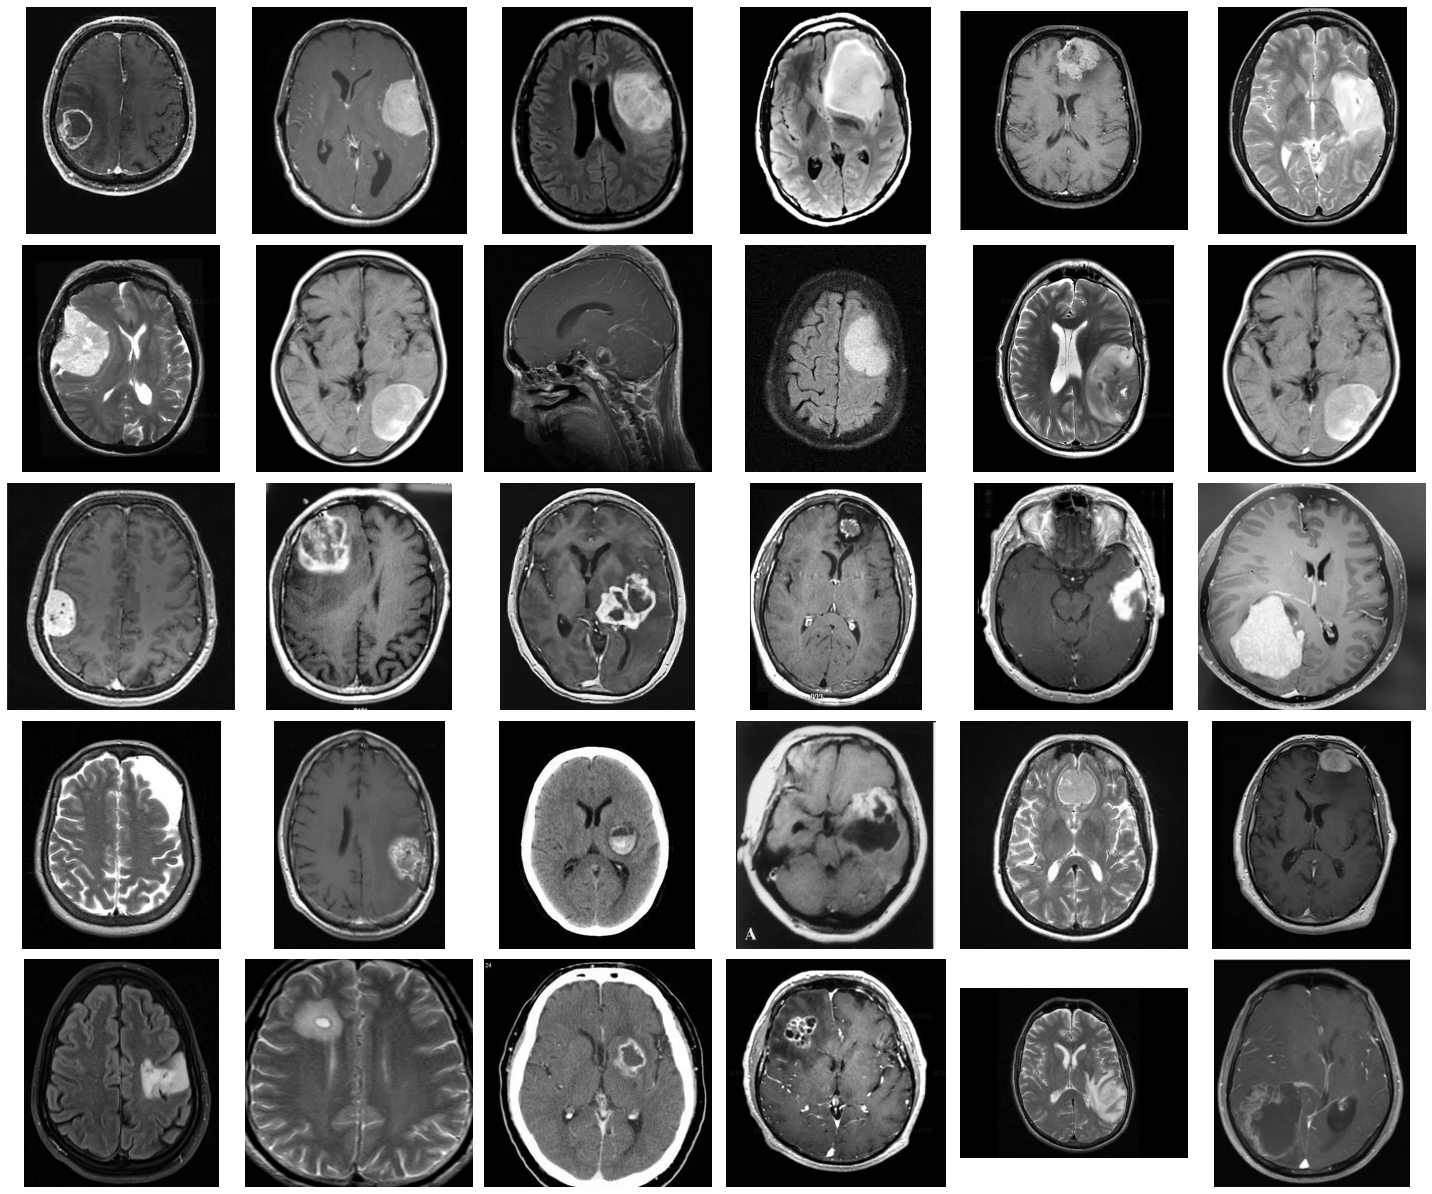

In [4]:
plt.figure(figsize=(20, 20))

for i in range(1 , 31):
    plt.subplot(6, 6, i )
    plt.imshow(Image.open(brain_tumors_images[i]) , cmap = 'gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

##**Needle and Localizing Tumor**

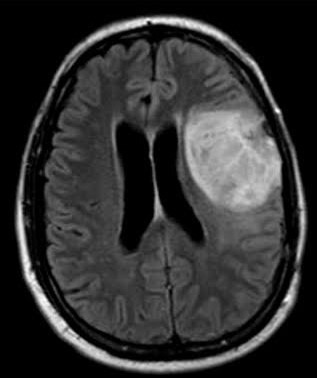

In [5]:
Image.open(brain_tumors_images[3]) # extracting tumor-needle from this image

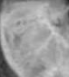

In [6]:
needle = cv2.imread('/content/drive/MyDrive/Datasets/needle/needle.png' , cv2.IMREAD_UNCHANGED)
cv2_imshow(needle)
example = cv2.imread(brain_tumors_images[1], cv2.IMREAD_UNCHANGED)

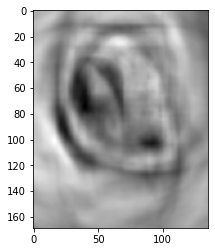

In [7]:
result = cv2.matchTemplate(example,needle, cv2.TM_CCOEFF_NORMED)
plt.imshow(result, cmap = 'gray')

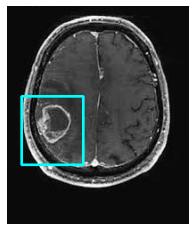

In [102]:
min_val,max_val,min_loc,max_loc = cv2.minMaxLoc(result)

w = needle.shape[1]
h = needle.shape[0]

highlighted = cv2.rectangle(example, max_loc, (max_loc[0] + w, max_loc[1] + h), (0,255,255) , 2)
plt.axis('off')
plt.imshow(highlighted) 

##**Example of Patients without Brain Tumor Cells**

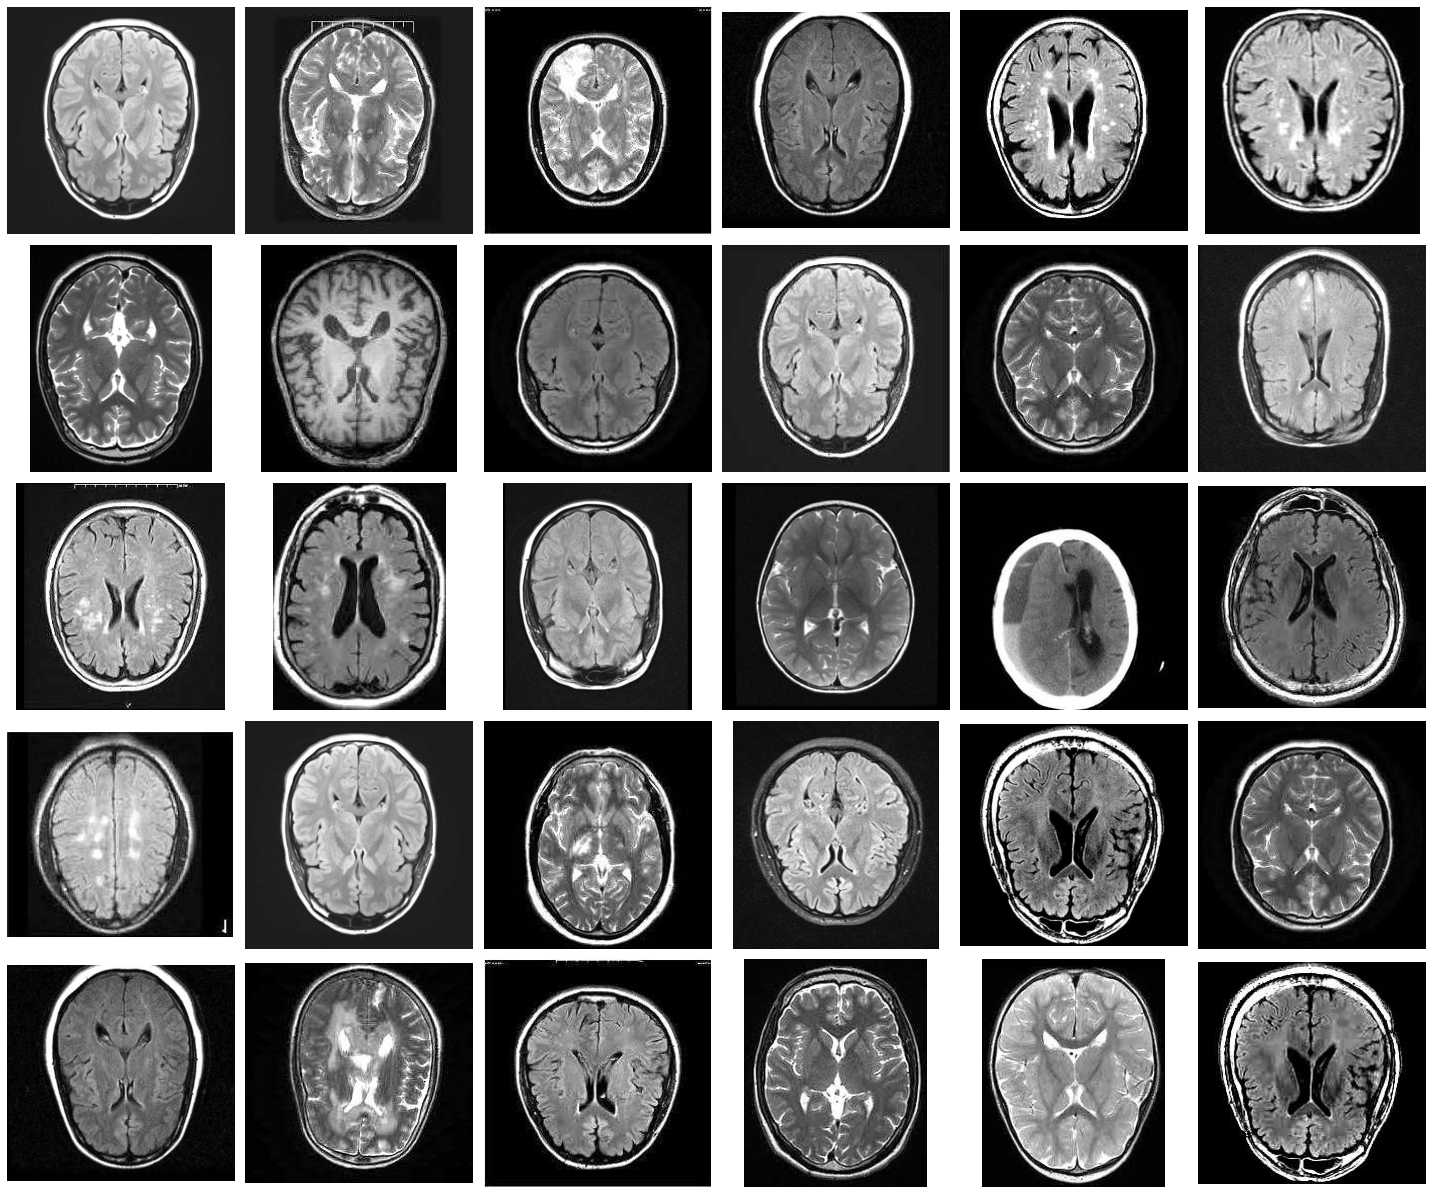

In [9]:
plt.figure(figsize=(20, 20))

for i in range(1 , 31):
    plt.subplot(6, 6, i )
    plt.imshow(Image.open(healthy_images[i]) , cmap = 'gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

###**Data Preparation**

In [10]:
nominated_label = [] 
filename = [] 
target = [] 
complete_file_local = [] 


for i in range(len(os.listdir(tumor_folder))):
  nominated_label.append('Tumor')
  target.append('1')
  filename.append('Brain Tumor/' + os.listdir(tumor_folder)[i])


for i in range(len(os.listdir(healthy_folder))):
  nominated_label.append('Healthy')
  target.append('0')
  filename.append('Healthy/' + os.listdir(healthy_folder)[i])

df = pd.DataFrame({
                   'filename': filename,
                   'nominated_label': nominated_label,
                   'target':target})
df


filename nominated_label target
0      Brain Tumor/Cancer (2311).jpg           Tumor      1
1      Brain Tumor/Cancer (2337).jpg           Tumor      1
2      Brain Tumor/Cancer (2305).jpg           Tumor      1
3      Brain Tumor/Cancer (2342).jpg           Tumor      1
4      Brain Tumor/Cancer (2360).jpg           Tumor      1
...                              ...             ...    ...
4595  Healthy/Not Cancer  (1077).jpg         Healthy      0
4596  Healthy/Not Cancer  (1063).jpg         Healthy      0
4597  Healthy/Not Cancer  (1054).jpg         Healthy      0
4598  Healthy/Not Cancer  (1072).jpg         Healthy      0
4599  Healthy/Not Cancer  (1061).jpg         Healthy      0

[4600 rows x 3 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  if __name__ == '__main__':


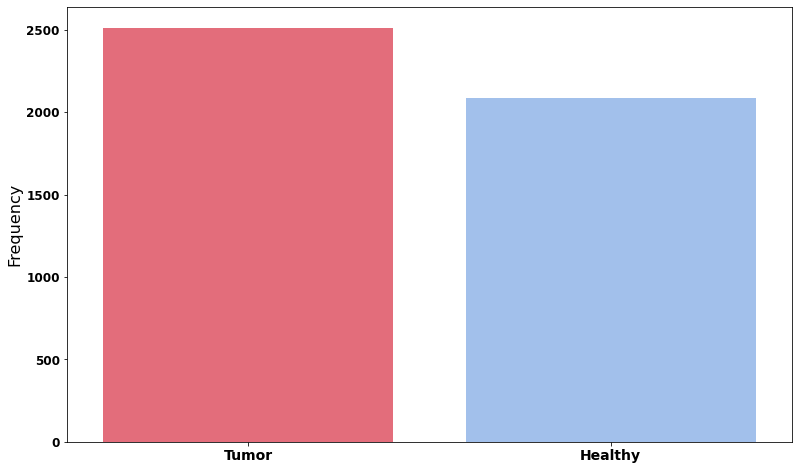

In [31]:
k = [ '#F7596C', '#96BEF7', '#F0E341']

plt.figure(figsize = (13,8))
sns.countplot(df.nominated_label, palette = k )
plt.xticks(size = 14 , weight = 'bold')
plt.yticks(size = 12 , weight = 'bold')
plt.xlabel('')
plt.ylabel('Frequency', size = 16)
plt.axis(color = 'white')

plt.show() 


In [12]:
df = shuffle(df) # shuffling dataframe 
df

filename nominated_label target
1133   Brain Tumor/Cancer (1524).jpg           Tumor      1
870     Brain Tumor/Cancer (873).jpg           Tumor      1
3480   Healthy/Not Cancer  (985).jpg         Healthy      0
4179  Healthy/Not Cancer  (1714).jpg         Healthy      0
3148   Healthy/Not Cancer  (681).jpg         Healthy      0
...                              ...             ...    ...
3138   Healthy/Not Cancer  (661).jpg         Healthy      0
3192   Healthy/Not Cancer  (658).jpg         Healthy      0
4463  Healthy/Not Cancer  (1901).jpg         Healthy      0
4271  Healthy/Not Cancer  (1721).jpg         Healthy      0
3089   Healthy/Not Cancer  (630).jpg         Healthy      0

[4600 rows x 3 columns]

In [13]:
x_train,x_test,y_train,y_test = train_test_split(df.filename,df.target, test_size = .1)

In [14]:
train_df = pd.DataFrame({'filename' : x_train,
                         'target': y_train})
train_df

filename target
969    Brain Tumor/Cancer (967).JPG      1
336    Brain Tumor/Cancer (425).jpg      1
2909  Healthy/Not Cancer  (495).jpg      0
973    Brain Tumor/Cancer (977).JPG      1
927    Brain Tumor/Cancer (966).jpg      1
...                             ...    ...
1319  Brain Tumor/Cancer (1743).jpg      1
2243  Brain Tumor/Cancer (1201).jpg      1
447    Brain Tumor/Cancer (483).jpg      1
2481  Brain Tumor/Cancer (1403).jpg      1
3385  Healthy/Not Cancer  (866).jpg      0

[4140 rows x 2 columns]

In [15]:
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test,test_size = .5)
test_df = pd.DataFrame({'filename':x_test,
                        'target':y_test})
test_df

filename target
2914   Healthy/Not Cancer  (448).jpg      0
474     Brain Tumor/Cancer (566).jpg      1
2023   Brain Tumor/Cancer (1071).jpg      1
49     Brain Tumor/Cancer (2387).jpg      1
503      Brain Tumor/Cancer (55).jpg      1
...                              ...    ...
4336  Healthy/Not Cancer  (1841).jpg      0
1606   Brain Tumor/Cancer (1966).jpg      1
1706   Brain Tumor/Cancer (2048).jpg      1
4136  Healthy/Not Cancer  (1612).jpg      0
2590  Healthy/Not Cancer  (2075).jpg      0

[230 rows x 2 columns]

In [16]:
val_df = pd.DataFrame({'filename':x_val,
                       'target': y_val})
val_df

filename target
4338  Healthy/Not Cancer  (1797).jpg      0
2645   Healthy/Not Cancer  (232).jpg      0
3456   Healthy/Not Cancer  (972).jpg      0
3723  Healthy/Not Cancer  (1278).jpg      0
2821   Healthy/Not Cancer  (431).jpg      0
...                              ...    ...
1084   Brain Tumor/Cancer (1548).jpg      1
4348  Healthy/Not Cancer  (1794).jpg      0
3932  Healthy/Not Cancer  (1458).jpg      0
247      Brain Tumor/Cancer (33).tif      1
2051    Brain Tumor/Cancer (108).jpg      1

[230 rows x 2 columns]

In [17]:
print('                             ______________________                              ')
print('\n')
print('Train Set ->  {} files in total , containing : {} in class 1 and {} in class 0 '.format(len(x_train) ,
                                                                                               train_df.target.value_counts()[1] , train_df.target.value_counts()[0]))

print('\n')
print('Test Set ->  {} files in total , containing : {} in class 1 and {} in class 0 '.format(len(x_test) ,
                                                                                               test_df.target.value_counts()[1] , test_df.target.value_counts()[0]))


print('\n')
print('Validation Set ->  {} files in total , containing : {} in class 1 and {} in class 0 '.format(len(x_val) ,
                                                                                               val_df.target.value_counts()[1] , val_df.target.value_counts()[0]))

print('________________________________________________________________________________________')

                             ______________________                              


Train Set ->  4140 files in total , containing : 1881 in class 1 and 2259 in class 0 


Test Set ->  230 files in total , containing : 99 in class 1 and 131 in class 0 


Validation Set ->  230 files in total , containing : 107 in class 1 and 123 in class 0 
________________________________________________________________________________________


In [40]:
datagen = ImageDataGenerator(rescale = 1./255)


train_data = datagen.flow_from_dataframe(train_df, x_col = 'filename',y_col = 'target',
                                         directory = '/content/drive/MyDrive/Datasets/Brain Tumor Data Set',
                                         target_size = (160,160),
                                         color_mode = 'grayscale', class_mode = 'binary') 

test_data = datagen.flow_from_dataframe(test_df, x_col = 'filename' , y_col = 'target',
                                        directory = '/content/drive/MyDrive/Datasets/Brain Tumor Data Set',
                                        target_size = (160,160) , color_mode = 'grayscale' , class_mode = 'binary',
                                        shuffle = False)



val_data = datagen.flow_from_dataframe(val_df, x_col = 'filename' , y_col = 'target',
                                        directory = '/content/drive/MyDrive/Datasets/Brain Tumor Data Set',
                                        target_size = (160,160) , color_mode = 'grayscale' , class_mode = 'binary',
                                       shuffle = True)

Found 4140 validated image filenames belonging to 2 classes.
Found 230 validated image filenames belonging to 2 classes.
Found 230 validated image filenames belonging to 2 classes.


##**Building Neural Networks**

In [19]:
model1 = Sequential()
model1.add(Conv2D(64,2, padding = 'same', 
                 input_shape = (160,160,1)))
model1.add(Activation('relu'))
model1.add(Conv2D(32, 2 , strides = 2, padding  = 'same'))
model1.add(Activation('relu'))
model1.add(MaxPool2D(pool_size = (2,2)))
model1.add(Conv2D(32, 2 , strides = 2, padding  = 'same'))
model1.add(Activation('relu'))
model1.add(MaxPool2D(pool_size = (2,2)))
model1.add(Dropout(.25))



model1.add(Flatten())
model1.add(Dense(64))
model1.add(Activation('relu'))
model1.add(Dropout(.33))
model1.add(Dense(1, activation= 'sigmoid'))

In [20]:
model1.compile(Adam(learning_rate = 1e-3), loss = 'binary_crossentropy',
              metrics = 'acc')

In [21]:
reducing_learning_rate_on_pl = ReduceLROnPlateau(monitor = 'val_loss',
                                                 patience = 0, verbose = 1,
                                                 min_lr = 1e-6, factor = .25)


earlystop = EarlyStopping(monitor = 'val_loss',
                          verbose = 1, patience = 1)

training_steps = train_data.n // train_data.batch_size
validation_steps = val_data.n // val_data.batch_size

hs = model1.fit_generator(train_data,steps_per_epoch = training_steps,epochs = 20, verbose = 1,
                     validation_data = val_data, validation_steps = validation_steps,
                     callbacks = [reducing_learning_rate_on_pl , earlystop])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
129/129 [==============================] - 33s 135ms/step - loss: 0.6455 - acc: 0.5861 - val_loss: 0.4540 - val_acc: 0.7812
Epoch 2/20
129/129 [==============================] - 21s 164ms/step - loss: 0.4436 - acc: 0.8045 - val_loss: 0.3651 - val_acc: 0.8304
Epoch 3/20
129/129 [==============================] - 19s 150ms/step - loss: 0.3205 - acc: 0.8678 - val_loss: 0.2813 - val_acc: 0.9018
Epoch 4/20
129/129 [==============================] - 17s 133ms/step - loss: 0.2645 - acc: 0.8913 - val_loss: 0.2232 - val_acc: 0.9018
Epoch 5/20
129/129 [==============================] - 17s 131ms/step - loss: 0.2008 - acc: 0.9318 - val_loss: 0.1971 - val_acc: 0.9241
Epoch 6/20
129/129 [==============================] - 18s 136ms/step - loss: 0.1698 - acc: 0.9342 - val_loss: 0.1718 - val_acc: 0.9330
Epoch 7/20
129/129 [==============================] - 18s 136ms/step - loss: 0.1348 - acc: 0.9504 - val_loss: 0.1734 - val_acc: 0.9375

Epoch 00007: ReduceLROnPlateau reducing learning rate 

In [41]:
model1.evaluate(test_data)

8/8 [==============================] - 1s 106ms/step - loss: 0.1335 - acc: 0.9522


[0.13351385295391083, 0.9521738886833191]

In [42]:
model1.save('brain_tumor.h5')

8/8 [==============================] - 1s 105ms/step - loss: 0.1335 - acc: 0.9522


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


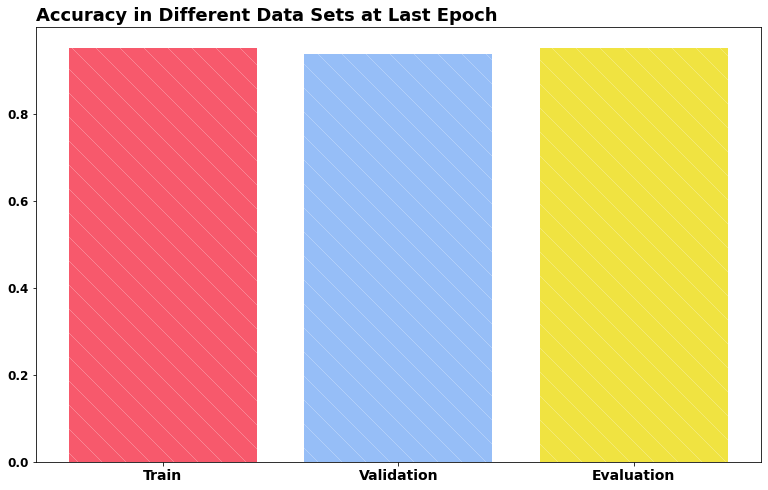

In [43]:
last_epoch_acc = hs.history['acc'][-1]
last_epoch_val_acc = hs.history['val_acc'][-1]
evaluation = model1.evaluate(test_data)[1]


ploting = {'Train': last_epoch_acc,
           'Validation': last_epoch_val_acc,
           'Evaluation' : evaluation}


plt.figure(figsize = (13,8))

instances = list(ploting.keys())
values = list(ploting.values())


plt.bar(instances,values, width = .8 , color = k,
        hatch = '\\')
plt.rcParams['hatch.linewidth'] = .2
plt.rcParams.update({'hatch.color' : 'white'})
plt.xticks(fontsize = 14 , weight  ='bold')
plt.yticks(fontsize = 12, weight = 'bold')
plt.axis(color = 'grey')
plt.title('Accuracy in Different Data Sets at Last Epoch' , loc = 'left', weight = 'bold', fontsize =18)
plt.show()

In [69]:
predictions = model1.predict_classes(test_data)
y_ = test_df.target.astype('int32')

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [70]:
test_data.class_indices

{'0': 0, '1': 1}

Text(0.5, 1.0, '0 = Healthy | 1 = Tumor')

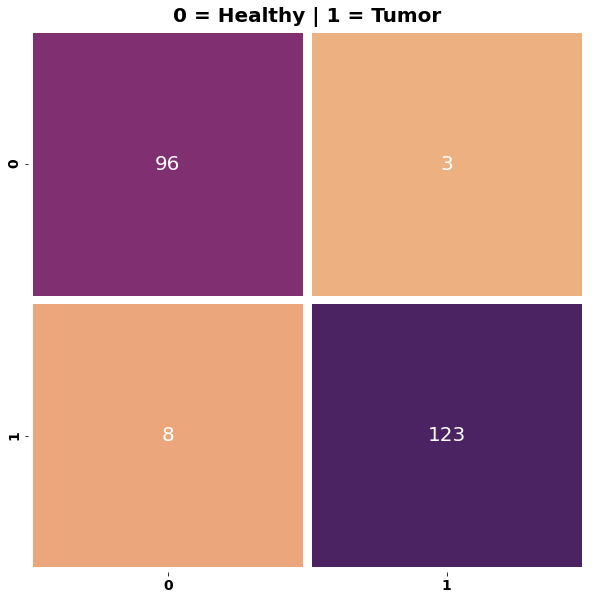

In [82]:
plt.figure(figsize = (10,10))
lbs = {0 : 'Healthy' , 1 : 'Tumor'}

cm = confusion_matrix(y_,predictions, labels = [0 , 1] )
htmp(cm, linewidths= 8,cbar = False, annot = True, fmt = 'g',
      annot_kws={"size":20 , 'color':'white'} , cmap = 'flare')

plt.xticks(size = 14 , weight = 'bold')
plt.yticks(size = 14 , weight = 'bold')
plt.title('0 = Healthy | 1 = Tumor' , fontsize = 20, weight = 'bold')

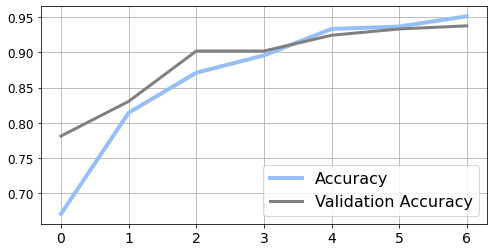

In [93]:
acc = hs.history['acc']
val_acc = hs.history['val_acc']


plt.figure(figsize = (8,4))
plt.plot(range(len(acc)), acc , label = 'Accuracy' , color = k[1], linewidth = 4)
plt.plot(val_acc, label = 'Validation Accuracy' , color = 'grey', linewidth = 3 )

plt.legend(fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 12)
plt.grid('off')
plt.show()


##**Transfer Learning Instance**

In [95]:
models = {'Resnet50': ResNet50(include_top = False , classes = 2,input_shape = ((160,160,3))),
          'Resnet101':ResNet101(include_top = False , classes = 2,input_shape = ((160,160,3))),
          'InceptionV3':InceptionV3(include_top = False , classes = 2,input_shape = ((160,160,3))),
          'InceptionResnet':InceptionResNetV2(include_top = False , classes = 2,input_shape = ((160,160,3))),
          'VGG19':VGG19(include_top = False  , classes = 2,input_shape = ((160,160,3))),
          'VGG16':VGG16(include_top = False , classes = 2,input_shape = ((160,160,3)))}

58892288/58889256 [==============================] - 0s 0us/step


In [98]:
datagen = ImageDataGenerator(rescale = 1./255)


train_data = datagen.flow_from_dataframe(train_df, x_col = 'filename',y_col = 'target',
                                         directory = '/content/drive/MyDrive/Datasets/Brain Tumor Data Set',
                                         target_size = (160,160),
                                         color_mode = 'rgb', class_mode = 'binary') 

test_data = datagen.flow_from_dataframe(test_df, x_col = 'filename' , y_col = 'target',
                                        directory = '/content/drive/MyDrive/Datasets/Brain Tumor Data Set',
                                        target_size = (160,160) , color_mode = 'rgb' , class_mode = 'binary',
                                        shuffle = False)



val_data = datagen.flow_from_dataframe(val_df, x_col = 'filename' , y_col = 'target',
                                        directory = '/content/drive/MyDrive/Datasets/Brain Tumor Data Set',
                                        target_size = (160,160) , color_mode = 'rgb' , class_mode = 'binary',
                                       shuffle = True)

Found 4140 validated image filenames belonging to 2 classes.
Found 230 validated image filenames belonging to 2 classes.
Found 230 validated image filenames belonging to 2 classes.


_______________________________________________________
_______________________________________________________


Training : Resnet50
Epoch 1/15
129/129 [==============================] - 24s 153ms/step - loss: 0.7182 - acc: 0.5783 - val_loss: 0.5691 - val_acc: 0.7411
Epoch 2/15
129/129 [==============================] - 19s 146ms/step - loss: 0.6142 - acc: 0.6714 - val_loss: 0.5349 - val_acc: 0.6920
Epoch 3/15
129/129 [==============================] - 19s 148ms/step - loss: 0.5599 - acc: 0.6953 - val_loss: 0.4765 - val_acc: 0.7679
Epoch 4/15
129/129 [==============================] - 18s 136ms/step - loss: 0.5073 - acc: 0.7318 - val_loss: 0.5613 - val_acc: 0.7321

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 00004: early stopping
8/8 [==============================] - 1s 119ms/step - loss: 0.5540 - acc: 0.7783



8/8 [==============================] - 1s 116ms/step - loss: 0.5540 - acc: 0.7783
------> EvaluatingResnet50 : [0.5539968013763428, 

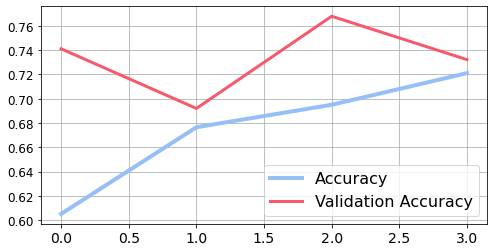

_______________________________________________________
_______________________________________________________


Training : Resnet101
Epoch 1/15
129/129 [==============================] - 27s 164ms/step - loss: 0.7128 - acc: 0.5604 - val_loss: 0.5235 - val_acc: 0.8080
Epoch 2/15
129/129 [==============================] - 20s 158ms/step - loss: 0.5574 - acc: 0.7104 - val_loss: 0.4865 - val_acc: 0.8393
Epoch 3/15
129/129 [==============================] - 20s 157ms/step - loss: 0.5047 - acc: 0.7426 - val_loss: 0.4551 - val_acc: 0.8080
Epoch 4/15
129/129 [==============================] - 20s 156ms/step - loss: 0.4674 - acc: 0.7790 - val_loss: 0.4412 - val_acc: 0.8304
Epoch 5/15
129/129 [==============================] - 20s 151ms/step - loss: 0.4851 - acc: 0.7581 - val_loss: 0.4419 - val_acc: 0.8661

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 00005: early stopping
8/8 [==============================] - 1s 137ms/step - loss: 0.4439 - acc: 0.8304

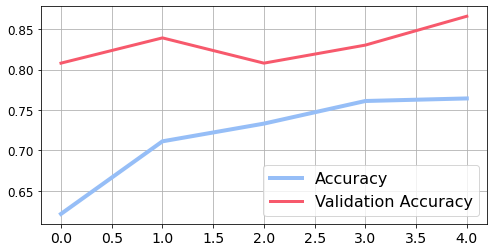

_______________________________________________________
_______________________________________________________


Training : InceptionV3
Epoch 1/15
129/129 [==============================] - 26s 159ms/step - loss: 1.1043 - acc: 0.6384 - val_loss: 0.4351 - val_acc: 0.8438
Epoch 2/15
129/129 [==============================] - 17s 133ms/step - loss: 0.3814 - acc: 0.8460 - val_loss: 0.2349 - val_acc: 0.8839
Epoch 3/15
129/129 [==============================] - 18s 139ms/step - loss: 0.2881 - acc: 0.8852 - val_loss: 0.2096 - val_acc: 0.9286
Epoch 4/15
129/129 [==============================] - 18s 141ms/step - loss: 0.2502 - acc: 0.8867 - val_loss: 0.1406 - val_acc: 0.9643
Epoch 5/15
129/129 [==============================] - 17s 134ms/step - loss: 0.2445 - acc: 0.8931 - val_loss: 0.1244 - val_acc: 0.9464
Epoch 6/15
129/129 [==============================] - 17s 133ms/step - loss: 0.1852 - acc: 0.9147 - val_loss: 0.1586 - val_acc: 0.9375

Epoch 00006: ReduceLROnPlateau reducing learning rat

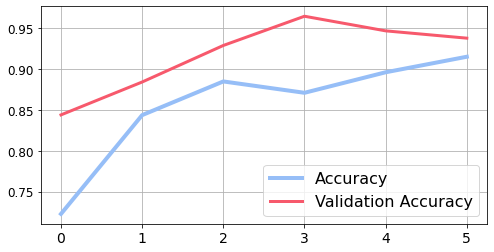

_______________________________________________________
_______________________________________________________


Training : InceptionResnet
Epoch 1/15
129/129 [==============================] - 37s 193ms/step - loss: 1.1124 - acc: 0.6847 - val_loss: 0.3728 - val_acc: 0.8393
Epoch 2/15
129/129 [==============================] - 23s 176ms/step - loss: 0.3454 - acc: 0.8415 - val_loss: 0.2693 - val_acc: 0.8929
Epoch 3/15
129/129 [==============================] - 21s 164ms/step - loss: 0.2886 - acc: 0.8700 - val_loss: 0.2630 - val_acc: 0.8795
Epoch 4/15
129/129 [==============================] - 23s 175ms/step - loss: 0.2135 - acc: 0.9081 - val_loss: 0.2092 - val_acc: 0.9196
Epoch 5/15
129/129 [==============================] - 22s 171ms/step - loss: 0.1877 - acc: 0.9234 - val_loss: 0.1956 - val_acc: 0.9241
Epoch 6/15
129/129 [==============================] - 23s 175ms/step - loss: 0.2181 - acc: 0.9235 - val_loss: 0.1830 - val_acc: 0.9062
Epoch 7/15
129/129 [=============================

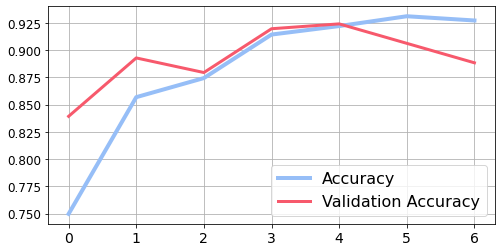

_______________________________________________________
_______________________________________________________


Training : VGG19
Epoch 1/15
129/129 [==============================] - 25s 154ms/step - loss: 0.6844 - acc: 0.6728 - val_loss: 0.3517 - val_acc: 0.8661
Epoch 2/15
129/129 [==============================] - 18s 136ms/step - loss: 0.3107 - acc: 0.8748 - val_loss: 0.2555 - val_acc: 0.9062
Epoch 3/15
129/129 [==============================] - 18s 141ms/step - loss: 0.2402 - acc: 0.9024 - val_loss: 0.2339 - val_acc: 0.9018
Epoch 4/15
129/129 [==============================] - 19s 145ms/step - loss: 0.2048 - acc: 0.9175 - val_loss: 0.2177 - val_acc: 0.9196
Epoch 5/15
129/129 [==============================] - 18s 137ms/step - loss: 0.1793 - acc: 0.9283 - val_loss: 0.2238 - val_acc: 0.9152

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 00005: early stopping
8/8 [==============================] - 2s 277ms/step - loss: 0.1238 - acc: 0.9478





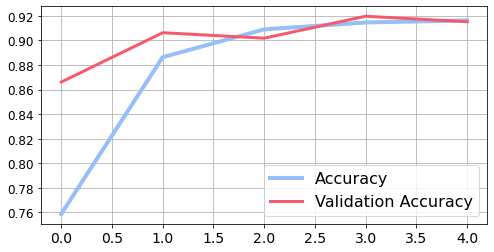

_______________________________________________________
_______________________________________________________


Training : VGG16
Epoch 1/15
129/129 [==============================] - 19s 139ms/step - loss: 0.5294 - acc: 0.7167 - val_loss: 0.2820 - val_acc: 0.8929
Epoch 2/15
129/129 [==============================] - 18s 140ms/step - loss: 0.2527 - acc: 0.9009 - val_loss: 0.2048 - val_acc: 0.9018
Epoch 3/15
129/129 [==============================] - 18s 140ms/step - loss: 0.1705 - acc: 0.9349 - val_loss: 0.1894 - val_acc: 0.9375
Epoch 4/15
129/129 [==============================] - 18s 137ms/step - loss: 0.1377 - acc: 0.9475 - val_loss: 0.1397 - val_acc: 0.9509
Epoch 5/15
129/129 [==============================] - 17s 133ms/step - loss: 0.1216 - acc: 0.9541 - val_loss: 0.1470 - val_acc: 0.9420

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 00005: early stopping
8/8 [==============================] - 1s 108ms/step - loss: 0.0664 - acc: 0.9783





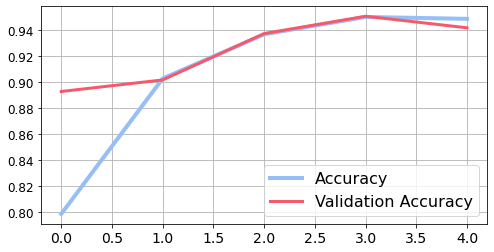

In [101]:
 
 
def build_model(base):
  model = Sequential()
  base.trainable = False
  model.add(base)
  model.add(Flatten())
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(.25))
  model.add(Dense(32 , activation = 'relu'))
  model.add(Dropout(.25))
  model.add(Dense(1, activation = 'sigmoid'))
  return model 
 
 
name = [] 
val_test_data = [] 
 
for MODEL in models:
  print('_______________________________________________________')
  print('_______________________________________________________')
  print('\n')
  print('Training : {}'.format(MODEL))
  base = models[MODEL]
  model = build_model(base)
  model.compile(Adam(learning_rate = 1e-3) , loss = 'binary_crossentropy', metrics = ['acc'])
  train_steps = train_data.n // train_data.batch_size
  val_steps = val_data.n // val_data.batch_size
  history = model.fit_generator(train_data,train_steps,epochs = 15,
                                validation_data = val_data,
                                validation_steps = val_steps,
                                callbacks = [reducing_learning_rate_on_pl,earlystop])
  
  eval = model.evaluate(test_data)
  print('\n\n')
  print('------> Evaluating{} : {} Accuracy in Test_data'.format(MODEL,model.evaluate(test_data)))
  print('\n')
  print('------------------- {} History ----------------------'.format(MODEL))
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  plt.figure(figsize = (8,4))
 
 
  plt.plot(range(0,len(acc)), acc, color = k[1] ,label = 'Accuracy', linewidth = 4)
  plt.plot(val_acc ,k[0], label = 'Validation Accuracy', linewidth = 3)
  
  plt.legend(fontsize = 16)
  plt.xticks(fontsize = 14)
  plt.yticks(fontsize = 12)
  plt.grid('off')
  plt.show()
  plt.show()
  name.append(MODEL)
  val_test_data.append(eval[1])

In [109]:
vgg = models['VGG16']

model = build_model(vgg)

for i in range(100):
  model.compile(Adam(learning_rate = 1e-3) , loss = 'binary_crossentropy', metrics = ['acc'])
  train_steps = train_data.n // train_data.batch_size
  val_steps = val_data.n // val_data.batch_size
  history = model.fit_generator(train_data,train_steps,epochs = 20,
                                  validation_data = val_data,
                                  validation_steps = val_steps,
                                  callbacks = [reducing_learning_rate_on_pl,earlystop])
  if model.evaluate(test_data)[1] >= 0.98:
    break

Epoch 1/20
129/129 [==============================] - 19s 139ms/step - loss: 0.5914 - acc: 0.7005 - val_loss: 0.2857 - val_acc: 0.8884
Epoch 2/20
129/129 [==============================] - 18s 136ms/step - loss: 0.2344 - acc: 0.9071 - val_loss: 0.2152 - val_acc: 0.9062
Epoch 3/20
129/129 [==============================] - 18s 139ms/step - loss: 0.1563 - acc: 0.9396 - val_loss: 0.2282 - val_acc: 0.9107

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 00003: early stopping
8/8 [==============================] - 1s 118ms/step - loss: 0.1566 - acc: 0.9348
Epoch 1/20
129/129 [==============================] - 18s 133ms/step - loss: 0.1493 - acc: 0.9462 - val_loss: 0.2006 - val_acc: 0.9196
Epoch 2/20
129/129 [==============================] - 17s 130ms/step - loss: 0.1238 - acc: 0.9539 - val_loss: 0.1916 - val_acc: 0.9420
Epoch 3/20
129/129 [==============================] - 20s 151ms/step - loss: 0.0956 - acc: 0.9604 - val_loss: 0.2096 - val_acc: 0.9420

In [113]:
model.save_weights('vgg_weights.h5')

In [114]:
model.evaluate(test_data)

8/8 [==============================] - 2s 182ms/step - loss: 0.0360 - acc: 0.9870


[0.03598698601126671, 0.9869565367698669]